### MIMIC ICU stays
Codes used to investigate ICU visits and length-of-stay
Author: Avon Huxor
Date: May 2017

In [1]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster
from sklearn import preprocessing
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
# load datafiles required
patients_df = pd.read_csv('PATIENTS.csv',parse_dates=['DOB','DOD','DOD_HOSP','DOD_SSN'])
icustays_df = pd.read_csv('ICUSTAYS.csv',parse_dates=['INTIME','OUTTIME'])


In [3]:
# view number of patients and number of ICU stays involved
print('patients_df = ',len(patients_df))
print('icustays_df = ',len(icustays_df))


patients_df =  46520
icustays_df =  61532


In [4]:
# view example patient record
patients_df[patients_df.SUBJECT_ID==18992]

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
15819,17943,18992,M,2084-02-29,2127-10-28,NaT,2127-10-28,1


#### remove neotal and cardiac surgical recovery units, as these unlike 4 main ICU types

In [5]:
# remove neonatal and cardiac surgery recovery from the icustays dataframe
icustays_df_four = icustays_df[(icustays_df.LAST_CAREUNIT!='NICU') & (icustays_df.LAST_CAREUNIT!='CSRU')]
len(icustays_df_four)

44040

In [6]:
# view example icu-stay record for our token patient
icustays_df_four[icustays_df_four.SUBJECT_ID==18992]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
28979,24062,18992,123291,224638,carevue,CCU,SICU,7,33,2124-04-21 06:12:15,2124-08-03 12:09:45,104.2483


In [7]:
# group by subject_d (patient) and then by icustays
# e.g. in table below 
subjects_icustays_df = icustays_df_four.groupby(['SUBJECT_ID','ICUSTAY_ID']).size().reset_index().groupby('SUBJECT_ID').count()
subjects_icustays_df_sorted = subjects_icustays_df.sort_values(by='ICUSTAY_ID',ascending=False)
subject_icustays_reindexed_df = subjects_icustays_df_sorted.reset_index()
subject_icustays_reindexed_df.head()


,SUBJECT_ID,ICUSTAY_ID,0
0,13033,41,41
1,109,38,38
2,11861,35,35
3,5060,30,30
4,20643,25,25


In [8]:
# get overview of numbers of visits, and number of patients involved in these
for n in range(1,20):
    disp_string = 'number of icu stays of '+ str(n) + ' visits = '
    print(disp_string, len(subject_icustays_reindexed_df[subject_icustays_reindexed_df.ICUSTAY_ID==n]))


number of icu stays of 1 visits =  24751
number of icu stays of 2 visits =  4445
number of icu stays of 3 visits =  1343
number of icu stays of 4 visits =  564
number of icu stays of 5 visits =  246
number of icu stays of 6 visits =  132
number of icu stays of 7 visits =  68
number of icu stays of 8 visits =  43
number of icu stays of 9 visits =  25
number of icu stays of 10 visits =  17
number of icu stays of 11 visits =  10
number of icu stays of 12 visits =  13
number of icu stays of 13 visits =  7
number of icu stays of 14 visits =  3
number of icu stays of 15 visits =  5
number of icu stays of 16 visits =  2
number of icu stays of 17 visits =  2
number of icu stays of 18 visits =  2
number of icu stays of 19 visits =  0


In [9]:
# lets get patients who have only one visit, to see if any stand out 
patients_with_only_one_visit = subject_icustays_reindexed_df[subject_icustays_reindexed_df.ICUSTAY_ID==1]
patients_with_only_one_visit
# merge with icustays db to get LOS
patients_one_visit_los_df = patients_with_only_one_visit.merge(icustays_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
patients_one_visit_los_df.LOS.describe()

count    25956.000000
mean         4.001919
std          5.797559
min          0.000100
25%          1.158500
50%          2.045150
75%          4.054600
max        104.248300
Name: LOS, dtype: float64

In [10]:
# we seem to have one patient 18992, who seems to have been in ICU for over 104 days in just one visit!
# this patient is the object a specific study: see patient_18992.ipynb
patients_one_visit_los_df[patients_one_visit_los_df.LOS >100]

,SUBJECT_ID,ICUSTAY_ID_x,0,ROW_ID,HADM_ID,ICUSTAY_ID_y,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
22513,18992,1,1,24062,123291,224638,carevue,CCU,SICU,7,33,2124-04-21 06:12:15,2124-08-03 12:09:45,104.2483


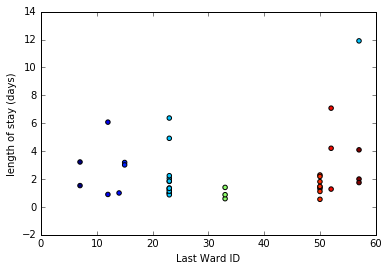

In [11]:
# e.g. subject 109 has had 38 stays
patient_109_stays = icustays_df_four[icustays_df_four.SUBJECT_ID==109]
# looking at these stays
# this patient seems to have been almost all ICUs in there time: MICU,SICU,TSICU, and CCU
# plot distribution of stays for this patient
plt.scatter(patient_109_stays.LAST_WARDID, patient_109_stays.LOS,c=patient_109_stays.FIRST_WARDID)
plt.xlabel('Last Ward ID')
plt.ylabel('length of stay (days)')

In [12]:
# loop through visit numbers and obtain numbers required for plots
mortality=[]
num_visits=[]
sample_size=[]
for j in range(0,15):
    temp = subject_icustays_reindexed_df[subject_icustays_reindexed_df.ICUSTAY_ID==j]
    if len(temp) !=0:
        multiples = temp.merge(patients_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
        multiples_died = multiples[pd.notnull(multiples.DOD_HOSP)]
        multiples_survived = multiples[pd.isnull(multiples.DOD_HOSP)]
        mortality_rate = len(multiples_died)/(len(multiples_survived)+len(multiples_died))
        mortality.append(mortality_rate)
        num_visits.append(j)
        sample_size.append(len(temp))


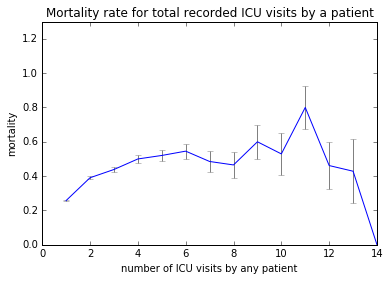

In [13]:
#plot 
mortality_ar = np.array(mortality)
error_estimate = np.sqrt(mortality_ar*(1-mortality_ar)/sample_size)
plt.errorbar(num_visits,mortality, yerr=error_estimate,ecolor='gray')
plt.xlabel('number of ICU visits by any patient')
plt.ylabel('mortality')
plt.ylim(0,1.3)
plt.title('Mortality rate for total recorded ICU visits by a patient')

plt.savefig("mortality_allICU_visits_plots.pdf", bbox_inches = 'tight',
    pad_inches = 0.1)



In [14]:
# get total time subject spent in ICU for each patient_id
subject_los_df = icustays_df_four.groupby(['SUBJECT_ID','LOS']).size().reset_index().groupby('SUBJECT_ID')['LOS'].sum()
subject_los_df_sorted = subject_los_df.sort_values()
subject_los_sorted_reindexed_df = subject_los_df_sorted.reset_index()
subject_los_death_stats_merged = subject_los_sorted_reindexed_df.merge(patients_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
subject_los_death_stats_merged_died = subject_los_death_stats_merged[pd.notnull(subject_los_death_stats_merged.DOD_HOSP)]
subject_los_death_stats_merged_survived = subject_los_death_stats_merged[pd.isnull(subject_los_death_stats_merged.DOD_HOSP)]


In [15]:
# view longest stays (days)
subject_los_sorted_reindexed_df.tail(10)

,SUBJECT_ID,LOS
31678,2187,123.0242
31679,22818,130.2998
31680,6702,132.7249
31681,78076,134.1599
31682,19911,152.7318
31683,6365,159.5050
31684,26277,177.5396
31685,25256,181.8735
31686,21280,189.7204
31687,12613,268.6245


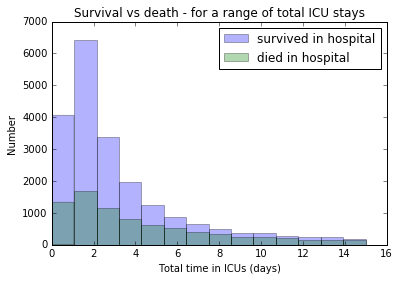

In [16]:
# plot histogram of survival and death in hosptital as a function of time in ICU
(n1, bins1, patches1) = plt.hist(subject_los_death_stats_merged_survived.LOS, normed=False, bins=14,range=[0.0, 15.0],alpha=0.3)
(n2, bins2, patches2) = plt.hist(subject_los_death_stats_merged_died.LOS, normed=False, bins=14,range=[0.0, 15.0],alpha=0.3)
plt.title('Survival vs death - for a range of total ICU stays')

plt.xlabel('Total time in ICUs (days)')
plt.ylabel('Number')
plt.legend(['survived in hospital','died in hospital'])

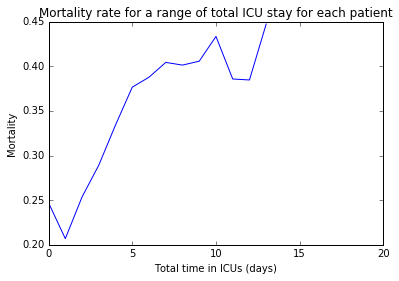

In [17]:
# plot line-plot of overall mortality as function of total ICU stay time
mortality2 = n2/(n1+n2)
len(mortality2)
plt.plot(mortality2)
plt.xlabel('Total time in ICUs (days)')
plt.ylabel('Mortality')
plt.xlim([0,20])
plt.title('Mortality rate for a range of total ICU stay for each patient')
plt.savefig("mortality_four_ICU_LOS_plot.pdf", bbox_inches = 'tight',
    pad_inches = 0.1)

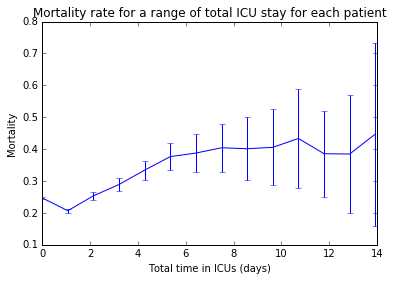

In [18]:
# plot line-plot of overall mortality as function of total ICU stay time
# version with error bars
mortality2 = n2/(n1+n2)

error_estimate = np.sqrt(mortality2*(1-mortality2)/sample_size) 
plt.errorbar(bins2[:-1],mortality2, yerr=error_estimate)
#plt.plot(mortality2)
plt.xlabel('Total time in ICUs (days)')
plt.ylabel('Mortality')
plt.title('Mortality rate for a range of total ICU stay for each patient')
plt.ylim([0.1,0.8])
plt.savefig("mortality_four_ICU_stay_days.pdf", bbox_inches = 'tight',
    pad_inches = 0.1)


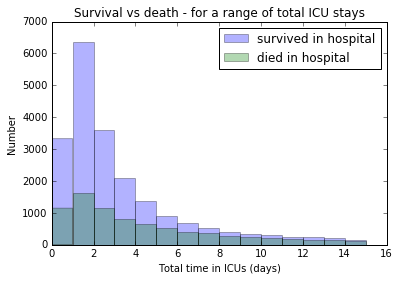

In [19]:
# plot histogram of survival and death in hosptital as a function of time in ICU
# for smaller bins to focus in on minimum at day 1 to 2
num_bins = 15
(n1, bins1, patches1) = plt.hist(subject_los_death_stats_merged_survived.LOS, normed=False, bins=num_bins,range=[0.0, 15.0],alpha=0.3)
(n2, bins2, patches2) = plt.hist(subject_los_death_stats_merged_died.LOS, normed=False, bins=num_bins,range=[0.0, 15.0],alpha=0.3)
plt.title('Survival vs death - for a range of total ICU stays')

plt.xlabel('Total time in ICUs (days)')
plt.ylabel('Number')
plt.legend(['survived in hospital','died in hospital'])

In [20]:
icustays_df.LAST_CAREUNIT.unique()

array(['MICU', 'CCU', 'SICU', 'NICU', 'TSICU', 'CSRU'], dtype=object)

In [21]:
icustays_df_MICU = icustays_df[icustays_df.LAST_CAREUNIT=='MICU']
icustays_df_CCU = icustays_df[icustays_df.LAST_CAREUNIT=='CCU']
icustays_df_SICU = icustays_df[icustays_df.LAST_CAREUNIT=='SICU']
icustays_df_NICU = icustays_df[icustays_df.LAST_CAREUNIT=='NICU']
icustays_df_TSICU = icustays_df[icustays_df.LAST_CAREUNIT=='TSICU']
icustays_df_CSRU = icustays_df[icustays_df.LAST_CAREUNIT=='CSRU']







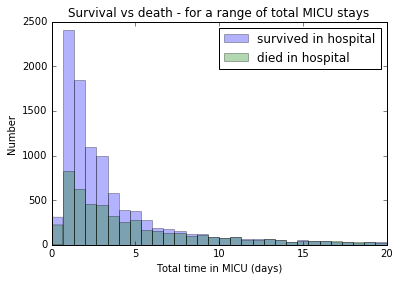

In [22]:
# get total time subject spent in MICU for each patient_id
subject_los_df_MICU = icustays_df_MICU.groupby(['SUBJECT_ID','LOS']).size().reset_index().groupby('SUBJECT_ID')['LOS'].sum()
subject_los_df_sorted_MICU = subject_los_df_MICU.sort_values()
subject_los_sorted_reindexed_df_MICU = subject_los_df_sorted_MICU.reset_index()
subject_los_death_stats_merged_MICU = subject_los_sorted_reindexed_df_MICU.merge(patients_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
subject_los_death_stats_merged_died_MICU = subject_los_death_stats_merged_MICU[pd.notnull(subject_los_death_stats_merged_MICU.DOD_HOSP)]
subject_los_death_stats_merged_survived_MICU = subject_los_death_stats_merged_MICU[pd.isnull(subject_los_death_stats_merged_MICU.DOD_HOSP)]


# plot histogram of survival and death in hosptital as a function of time in MICU
(n1_MICU, bins1_MICU, patches1_MICU) = plt.hist(subject_los_death_stats_merged_survived_MICU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
(n2_MICU, bins2_MICU, patches2_MICU) = plt.hist(subject_los_death_stats_merged_died_MICU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
plt.title('Survival vs death - for a range of total MICU stays')

plt.xlabel('Total time in MICU (days)')
plt.ylabel('Number')
plt.legend(['survived in hospital','died in hospital'])

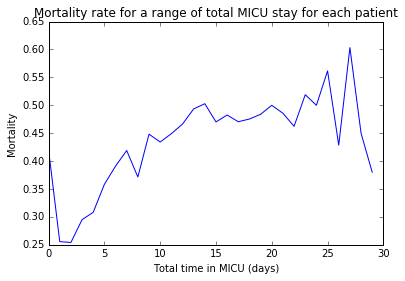

In [23]:
# plot line-plot of overall mortality as function of total ICU stay time
mortality2_MICU = n2_MICU/(n1_MICU + n2_MICU)
len(mortality2_MICU)
plt.plot(mortality2_MICU)
plt.xlabel('Total time in MICU (days)')
plt.ylabel('Mortality')
plt.title('Mortality rate for a range of total MICU stay for each patient')

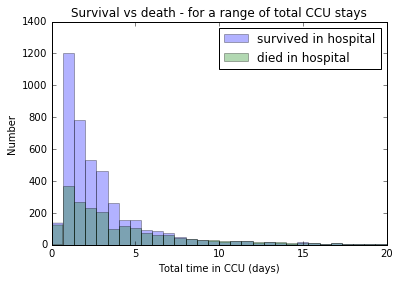

In [24]:
# get total time subject spent in CCU for each patient_id
subject_los_df_CCU = icustays_df_CCU.groupby(['SUBJECT_ID','LOS']).size().reset_index().groupby('SUBJECT_ID')['LOS'].sum()
subject_los_df_sorted_CCU = subject_los_df_CCU.sort_values()
subject_los_sorted_reindexed_df_CCU = subject_los_df_sorted_CCU.reset_index()
subject_los_death_stats_merged_CCU = subject_los_sorted_reindexed_df_CCU.merge(patients_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
subject_los_death_stats_merged_died_CCU = subject_los_death_stats_merged_CCU[pd.notnull(subject_los_death_stats_merged_CCU.DOD_HOSP)]
subject_los_death_stats_merged_survived_CCU = subject_los_death_stats_merged_CCU[pd.isnull(subject_los_death_stats_merged_CCU.DOD_HOSP)]


# plot histogram of survival and death in hosptital as a function of time in CCU
(n1_CCU, bins1_CCU, patches1_CCU) = plt.hist(subject_los_death_stats_merged_survived_CCU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
(n2_CCU, bins2_CCU, patches2_CCU) = plt.hist(subject_los_death_stats_merged_died_CCU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
plt.title('Survival vs death - for a range of total CCU stays')

plt.xlabel('Total time in CCU (days)')
plt.ylabel('Number')
plt.legend(['survived in hospital','died in hospital'])

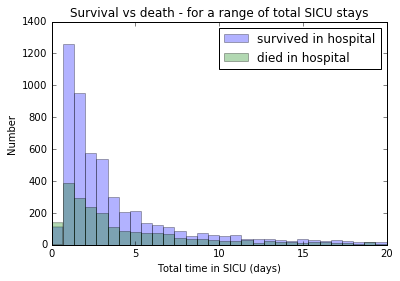

In [25]:
# get total time subject spent in SICU for each patient_id
subject_los_df_SICU = icustays_df_SICU.groupby(['SUBJECT_ID','LOS']).size().reset_index().groupby('SUBJECT_ID')['LOS'].sum()
subject_los_df_sorted_SICU = subject_los_df_SICU.sort_values()
subject_los_sorted_reindexed_df_SICU = subject_los_df_sorted_SICU.reset_index()
subject_los_death_stats_merged_SICU = subject_los_sorted_reindexed_df_SICU.merge(patients_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
subject_los_death_stats_merged_died_SICU = subject_los_death_stats_merged_SICU[pd.notnull(subject_los_death_stats_merged_SICU.DOD_HOSP)]
subject_los_death_stats_merged_survived_SICU = subject_los_death_stats_merged_SICU[pd.isnull(subject_los_death_stats_merged_SICU.DOD_HOSP)]


# plot histogram of survival and death in hosptital as a function of time in SICU
(n1_SICU, bins1_SICU, patches1_SICU) = plt.hist(subject_los_death_stats_merged_survived_SICU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
(n2_SICU, bins2_SICU, patches2_SICU) = plt.hist(subject_los_death_stats_merged_died_SICU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
plt.title('Survival vs death - for a range of total SICU stays')

plt.xlabel('Total time in SICU (days)')
plt.ylabel('Number')
plt.legend(['survived in hospital','died in hospital'])

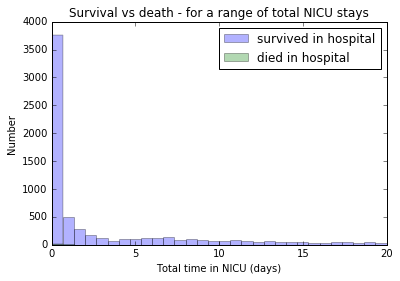

In [26]:
# get total time subject spent in NICU for each patient_id
subject_los_df_NICU = icustays_df_NICU.groupby(['SUBJECT_ID','LOS']).size().reset_index().groupby('SUBJECT_ID')['LOS'].sum()
subject_los_df_sorted_NICU = subject_los_df_NICU.sort_values()
subject_los_sorted_reindexed_df_NICU = subject_los_df_sorted_NICU.reset_index()
subject_los_death_stats_merged_NICU = subject_los_sorted_reindexed_df_NICU.merge(patients_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
subject_los_death_stats_merged_died_NICU = subject_los_death_stats_merged_NICU[pd.notnull(subject_los_death_stats_merged_NICU.DOD_HOSP)]
subject_los_death_stats_merged_survived_NICU = subject_los_death_stats_merged_NICU[pd.isnull(subject_los_death_stats_merged_NICU.DOD_HOSP)]


# plot histogram of survival and death in hosptital as a function of time in NICU
(n1_NICU, bins1_NICU, patches1_NICU) = plt.hist(subject_los_death_stats_merged_survived_NICU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
(n2_NICU, bins2_NICU, patches2_NICU) = plt.hist(subject_los_death_stats_merged_died_NICU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
plt.title('Survival vs death - for a range of total NICU stays')

plt.xlabel('Total time in NICU (days)')
plt.ylabel('Number')
plt.legend(['survived in hospital','died in hospital'])
plt.savefig("mortality_NICU_LOS_plot.pdf", bbox_inches = 'tight',
    pad_inches = 0.1)

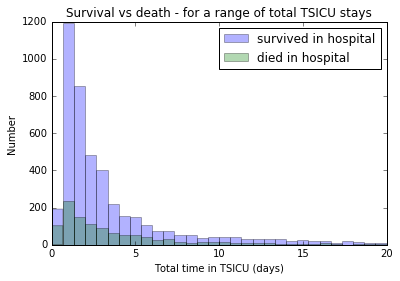

In [27]:
# get total time subject spent in TSICU for each patient_id
subject_los_df_TSICU = icustays_df_TSICU.groupby(['SUBJECT_ID','LOS']).size().reset_index().groupby('SUBJECT_ID')['LOS'].sum()
subject_los_df_sorted_TSICU = subject_los_df_TSICU.sort_values()
subject_los_sorted_reindexed_df_TSICU = subject_los_df_sorted_TSICU.reset_index()
subject_los_death_stats_merged_TSICU = subject_los_sorted_reindexed_df_TSICU.merge(patients_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
subject_los_death_stats_merged_died_TSICU = subject_los_death_stats_merged_TSICU[pd.notnull(subject_los_death_stats_merged_TSICU.DOD_HOSP)]
subject_los_death_stats_merged_survived_TSICU = subject_los_death_stats_merged_TSICU[pd.isnull(subject_los_death_stats_merged_TSICU.DOD_HOSP)]


# plot histogram of survival and death in hosptital as a function of time in TSICU
(n1_TSICU, bins1_TSICU, patches1_TSICU) = plt.hist(subject_los_death_stats_merged_survived_TSICU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
(n2_TSICU, bins2_TSICU, patches2_TSICU) = plt.hist(subject_los_death_stats_merged_died_TSICU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
plt.title('Survival vs death - for a range of total TSICU stays')

plt.xlabel('Total time in TSICU (days)')
plt.ylabel('Number')
plt.legend(['survived in hospital','died in hospital'])

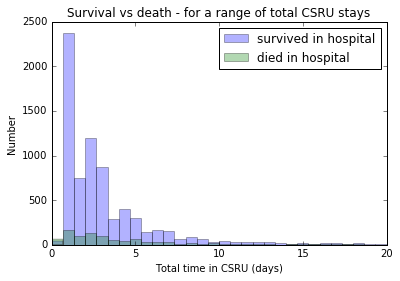

In [28]:
# get total time subject spent in CSRU for each patient_id
subject_los_df_CSRU = icustays_df_CSRU.groupby(['SUBJECT_ID','LOS']).size().reset_index().groupby('SUBJECT_ID')['LOS'].sum()
subject_los_df_sorted_CSRU = subject_los_df_CSRU.sort_values()
subject_los_sorted_reindexed_df_CSRU = subject_los_df_sorted_CSRU.reset_index()
subject_los_death_stats_merged_CSRU = subject_los_sorted_reindexed_df_CSRU.merge(patients_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
subject_los_death_stats_merged_died_CSRU = subject_los_death_stats_merged_CSRU[pd.notnull(subject_los_death_stats_merged_CSRU.DOD_HOSP)]
subject_los_death_stats_merged_survived_CSRU = subject_los_death_stats_merged_CSRU[pd.isnull(subject_los_death_stats_merged_CSRU.DOD_HOSP)]


# plot histogram of survival and death in hosptital as a function of time in CSRU
(n1_CSRU, bins1_CSRU, patches1_CSRU) = plt.hist(subject_los_death_stats_merged_survived_CSRU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
(n2_CSRU, bins2_CSRU, patches2_CSRU) = plt.hist(subject_los_death_stats_merged_died_CSRU.LOS, normed=False, bins=30,range=[0.0, 20.0],alpha=0.3)
plt.title('Survival vs death - for a range of total CSRU stays')

plt.xlabel('Total time in CSRU (days)')
plt.ylabel('Number')
plt.legend(['survived in hospital','died in hospital'])

In [29]:
microbiologyevents_df = pd.read_csv('MICROBIOLOGYEVENTS.csv')


In [30]:
all_stay_patients = subject_los_death_stats_merged

In [31]:
all_stay_patients_micro_merge =  all_stay_patients.merge(microbiologyevents_df, left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
len(all_stay_patients_micro_merge)

573740

In [32]:
all_micro = all_stay_patients_micro_merge.groupby('SUBJECT_ID').size().reset_index()
all_micro_los = all_micro.merge(subject_los_death_stats_merged,left_on='SUBJECT_ID',right_on='SUBJECT_ID', how='inner')
all_micro_los

,SUBJECT_ID,0,LOS,ROW_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,3,17,6.0646,2,M,2025-04-11,2102-06-14,NaT,2102-06-14,1
1,4,16,1.6785,3,F,2143-05-12,NaT,NaT,NaT,0
2,9,14,5.3231,8,M,2108-01-26,2149-11-14,2149-11-14,2149-11-14,1
3,11,1,1.5844,10,F,2128-02-22,2178-11-14,NaT,2178-11-14,1
4,12,14,7.6348,11,M,2032-03-24,2104-08-20,2104-08-20,2104-08-20,1
5,19,1,1.3017,16,M,1808-08-05,2109-08-18,NaT,2109-08-18,1
6,21,26,14.2664,18,M,2047-04-04,2135-02-08,2135-02-08,2135-02-08,1
7,22,1,1.1438,19,F,2131-05-07,NaT,NaT,NaT,0
8,23,2,1.1862,20,M,2082-07-17,NaT,NaT,NaT,0
9,25,2,3.5466,22,M,2101-11-21,NaT,NaT,NaT,0


In [33]:
all_micro_los.columns.values[1] = 'NUMBER_OF_EVENTS'


In [34]:
all_micro_los.columns= ['SUBJECT_ID', 'NUMBER_OF_EVENTS', 'LOS', 'ROW_ID', 'GENDER', 'DOB',
       'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG']

(0, 30)

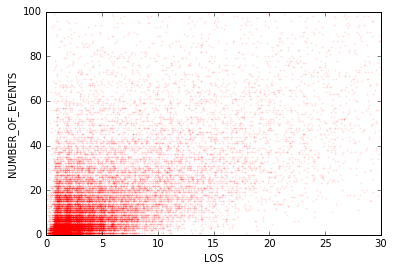

In [35]:
all_micro_los.plot.scatter('LOS','NUMBER_OF_EVENTS',c='red',alpha=0.1,s=5,marker='+')
plt.ylim([0,100])
plt.xlim([0,30])


In [36]:
all_micro_los_subset = all_micro_los[(all_micro_los.LOS<20) & (all_micro_los.NUMBER_OF_EVENTS<30)]

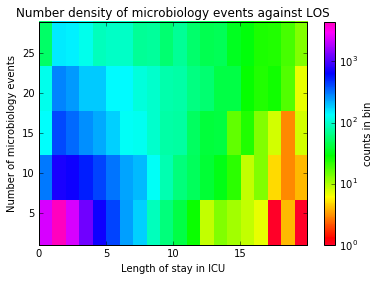

In [37]:
plt.hist2d(all_micro_los_subset.LOS, all_micro_los_subset.NUMBER_OF_EVENTS, bins=[20,5], cmap='gist_rainbow',norm = LogNorm())
cb = plt.colorbar()
cb.set_label('counts in bin')
plt.xlabel('Length of stay in ICU')
plt.ylabel('Number of microbiology events')
plt.title('Number density of microbiology events against LOS')
plt.savefig("micro_lab_events_LOS_heatmap.pdf", bbox_inches = 'tight',
    pad_inches = 0.1)
